## Training VGG16 on CIFAR10 Dataset

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets 
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Number of GPUs available: ',torch.cuda.device_count())
device

Number of GPUs available:  1


device(type='cuda', index=0)

In [4]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_feature, out_feature, num_layers, pool = False):
        super(ConvBlock, self).__init__()
        channels = [in_feature] + [out_feature for i in range(num_layers)]
        layers = []
        for i in range(num_layers):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size= 3, padding= 1, bias = True))
            layers.append(nn.BatchNorm2d(channels[i+1], affine = True, track_running_stats= True))
            layers.append(nn.ReLU())
            if pool:
                layers.append(nn.MaxPool2d(kernel_size= 2, stride = 2, padding= 0))
            
        self.op = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.op(x)

In [5]:
class Vgg(nn.Module):
    
    def __init__(self):
        super(Vgg, self).__init__()
        self.conv_block1 = ConvBlock(3, 64, 2)
        self.conv_block2 = ConvBlock(64, 128, 2)
        self.conv_block3 = ConvBlock(128, 256, 3)
        self.conv_block4 = ConvBlock(256, 512, 3)
        self.conv_block5 = ConvBlock(512, 512, 3)
        self.fc1 = nn.Linear(in_features= 512*2*2, out_features= 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
    def forward(self, x):
        #feed forward
        x = self.conv_block1(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /16
        x = self.conv_block2(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /8
        x = self.conv_block3(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 2, padding= 0) # /4
        x = self.conv_block4(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 1, padding= 0) # /2
        x = self.conv_block5(x)
        x = F.max_pool2d(x, kernel_size= 2, stride= 1, padding= 0)
        
        B, C, H, W = x.shape
        l = x.reshape(-1, C*H*W)
        l = self.fc1(l)
        l = F.relu(l)
        l = self.fc2(l)
        l = F.relu(l)
        out = self.fc3(l)
        
        return F.softmax(out,1)

In [6]:
class Data():
    
    def __init__(self):
        
        self.train_set = datasets.CIFAR10(
        root = './data',
        train = True,
        download = True,
        transform = transforms.Compose([transforms.ToTensor()])
        )

        self.test_set = datasets.CIFAR10(
        root= './data',
        train= False,
        download = True,
        transform = transforms.Compose([transforms.ToTensor()])
        )
        
    def get_data(self):
        return [self.train_set, self.test_set]

In [7]:
data = Data()
train, test = data.get_data()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(train, batch_size= 512, shuffle= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 10000, shuffle= True)

In [9]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([512, 3, 32, 32])

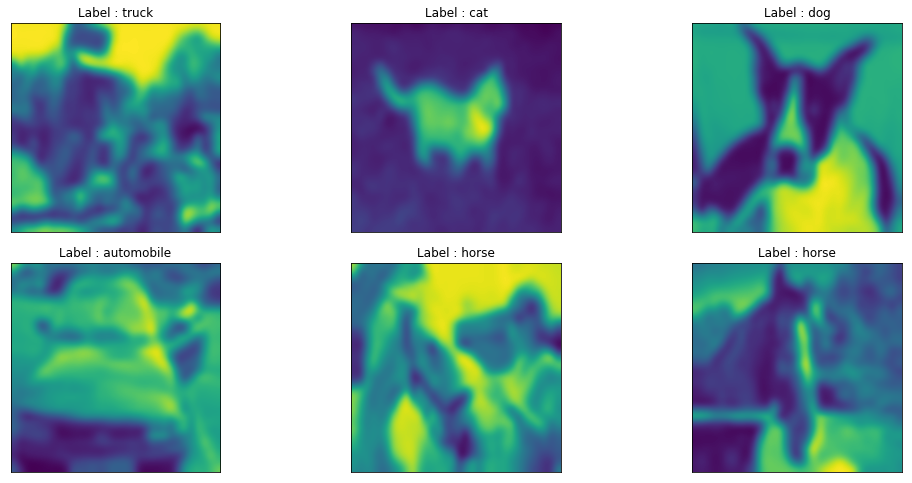

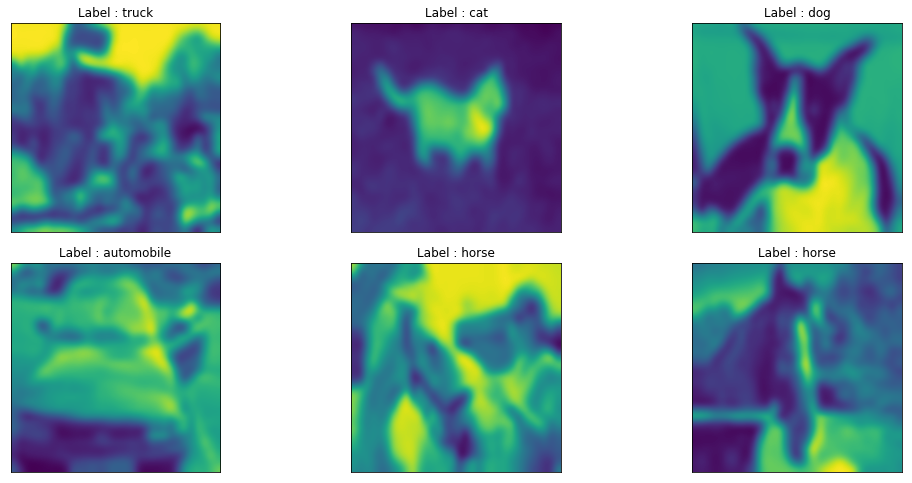

In [10]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], interpolation='bicubic')
  plt.title("Label : {}".format(train.classes[labels[i]]))
  plt.xticks([])
  plt.yticks([])
fig

In [11]:
#net = models.vgg16(pretrained=True)
net = Vgg()
# use multiple gpus
#if torch.cuda.device_count() > 1:
    #net = nn.DataParallel(net)
    
net.to(device)

Vgg(
  (conv_block1): ConvBlock(
    (op): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block2): ConvBlock(
    (op): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block3): ConvBlock(
    (op): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
def train(epoch, losses):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        losses.append(loss.item())
        _, predicted = outputs.max(1)  #this returns values and labels
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [13]:
def test(test_loader,test_losses ):
    
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_losses.append(loss.item())
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Loss: %.3f | Acc: %.3f%%'
                  % (test_loss, 100.*correct/len(test_loader.dataset)))

In [14]:

losses = []
test_losses = []

epochs = 6
for epoch in range(1,epochs+1):
    train(epoch, losses)
    test(test_loader, test_losses)


Epoch: 1
0 98 Loss: 2.303 | Acc: 7.422% (38/512)
1 98 Loss: 2.303 | Acc: 9.668% (99/1024)
2 98 Loss: 2.303 | Acc: 9.505% (146/1536)
3 98 Loss: 2.303 | Acc: 10.059% (206/2048)
4 98 Loss: 2.303 | Acc: 9.805% (251/2560)
5 98 Loss: 2.303 | Acc: 9.440% (290/3072)
6 98 Loss: 2.303 | Acc: 9.682% (347/3584)
7 98 Loss: 2.303 | Acc: 9.668% (396/4096)
8 98 Loss: 2.303 | Acc: 9.570% (441/4608)
9 98 Loss: 2.303 | Acc: 9.551% (489/5120)
10 98 Loss: 2.303 | Acc: 9.535% (537/5632)
11 98 Loss: 2.303 | Acc: 9.521% (585/6144)
12 98 Loss: 2.303 | Acc: 9.525% (634/6656)
13 98 Loss: 2.303 | Acc: 9.501% (681/7168)
14 98 Loss: 2.303 | Acc: 9.492% (729/7680)
15 98 Loss: 2.303 | Acc: 9.473% (776/8192)
16 98 Loss: 2.303 | Acc: 9.547% (831/8704)
17 98 Loss: 2.303 | Acc: 9.494% (875/9216)
18 98 Loss: 2.303 | Acc: 9.539% (928/9728)
19 98 Loss: 2.303 | Acc: 9.512% (974/10240)
20 98 Loss: 2.303 | Acc: 9.570% (1029/10752)
21 98 Loss: 2.303 | Acc: 9.499% (1070/11264)
22 98 Loss: 2.303 | Acc: 9.604% (1131/11776)
23 98 

83 98 Loss: 2.298 | Acc: 13.883% (5971/43008)
84 98 Loss: 2.298 | Acc: 13.856% (6030/43520)
85 98 Loss: 2.298 | Acc: 13.829% (6089/44032)
86 98 Loss: 2.298 | Acc: 13.820% (6156/44544)
87 98 Loss: 2.298 | Acc: 13.805% (6220/45056)
88 98 Loss: 2.298 | Acc: 13.815% (6295/45568)
89 98 Loss: 2.298 | Acc: 13.798% (6358/46080)
90 98 Loss: 2.298 | Acc: 13.786% (6423/46592)
91 98 Loss: 2.298 | Acc: 13.791% (6496/47104)
92 98 Loss: 2.298 | Acc: 13.783% (6563/47616)
93 98 Loss: 2.297 | Acc: 13.794% (6639/48128)
94 98 Loss: 2.297 | Acc: 13.766% (6696/48640)
95 98 Loss: 2.297 | Acc: 13.725% (6746/49152)
96 98 Loss: 2.297 | Acc: 13.718% (6813/49664)
97 98 Loss: 2.297 | Acc: 13.714% (6857/50000)
Loss: 2.292 | Acc: 11.820%

Epoch: 3
0 98 Loss: 2.293 | Acc: 13.086% (67/512)
1 98 Loss: 2.293 | Acc: 11.914% (122/1024)
2 98 Loss: 2.293 | Acc: 12.435% (191/1536)
3 98 Loss: 2.293 | Acc: 12.158% (249/2048)
4 98 Loss: 2.293 | Acc: 12.266% (314/2560)
5 98 Loss: 2.293 | Acc: 12.207% (375/3072)
6 98 Loss: 2.293 

67 98 Loss: 2.258 | Acc: 17.291% (6020/34816)
68 98 Loss: 2.258 | Acc: 17.287% (6107/35328)
69 98 Loss: 2.258 | Acc: 17.288% (6196/35840)
70 98 Loss: 2.258 | Acc: 17.342% (6304/36352)
71 98 Loss: 2.258 | Acc: 17.375% (6405/36864)
72 98 Loss: 2.258 | Acc: 17.385% (6498/37376)
73 98 Loss: 2.257 | Acc: 17.407% (6595/37888)
74 98 Loss: 2.257 | Acc: 17.424% (6691/38400)
75 98 Loss: 2.257 | Acc: 17.411% (6775/38912)
76 98 Loss: 2.257 | Acc: 17.423% (6869/39424)
77 98 Loss: 2.257 | Acc: 17.408% (6952/39936)
78 98 Loss: 2.257 | Acc: 17.430% (7050/40448)
79 98 Loss: 2.257 | Acc: 17.427% (7138/40960)
80 98 Loss: 2.257 | Acc: 17.429% (7228/41472)
81 98 Loss: 2.257 | Acc: 17.409% (7309/41984)
82 98 Loss: 2.257 | Acc: 17.444% (7413/42496)
83 98 Loss: 2.257 | Acc: 17.471% (7514/43008)
84 98 Loss: 2.257 | Acc: 17.518% (7624/43520)
85 98 Loss: 2.257 | Acc: 17.521% (7715/44032)
86 98 Loss: 2.257 | Acc: 17.547% (7816/44544)
87 98 Loss: 2.257 | Acc: 17.569% (7916/45056)
88 98 Loss: 2.256 | Acc: 17.593% (

51 98 Loss: 2.214 | Acc: 23.757% (6325/26624)
52 98 Loss: 2.214 | Acc: 23.817% (6463/27136)
53 98 Loss: 2.214 | Acc: 23.843% (6592/27648)
54 98 Loss: 2.214 | Acc: 23.871% (6722/28160)
55 98 Loss: 2.214 | Acc: 23.954% (6868/28672)
56 98 Loss: 2.214 | Acc: 23.921% (6981/29184)
57 98 Loss: 2.214 | Acc: 23.953% (7113/29696)
58 98 Loss: 2.214 | Acc: 23.954% (7236/30208)
59 98 Loss: 2.214 | Acc: 23.991% (7370/30720)
60 98 Loss: 2.213 | Acc: 24.091% (7524/31232)
61 98 Loss: 2.213 | Acc: 24.131% (7660/31744)
62 98 Loss: 2.213 | Acc: 24.110% (7777/32256)
63 98 Loss: 2.213 | Acc: 24.170% (7920/32768)
64 98 Loss: 2.213 | Acc: 24.255% (8072/33280)
65 98 Loss: 2.213 | Acc: 24.260% (8198/33792)
66 98 Loss: 2.212 | Acc: 24.309% (8339/34304)
67 98 Loss: 2.212 | Acc: 24.339% (8474/34816)
68 98 Loss: 2.212 | Acc: 24.363% (8607/35328)
69 98 Loss: 2.212 | Acc: 24.422% (8753/35840)
70 98 Loss: 2.212 | Acc: 24.475% (8897/36352)
71 98 Loss: 2.212 | Acc: 24.476% (9023/36864)
72 98 Loss: 2.212 | Acc: 24.529% (

Text(0.5,0,'Epochs')

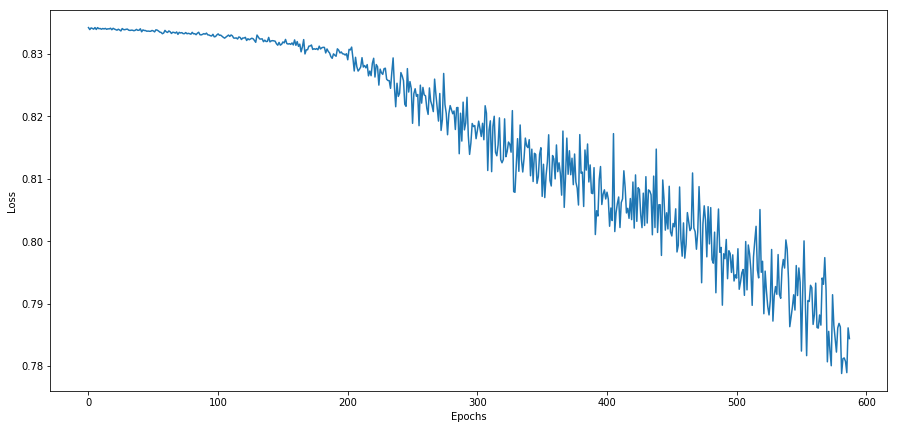

In [15]:
log_loss = [np.log(x) for x in losses]
plt.plot(log_loss)

plt.ylabel('Loss')
plt.xlabel('Epochs')

In [16]:
test_losses

[2.3001482486724854,
 2.291841506958008,
 2.2662203311920166,
 2.2458765506744385,
 2.223236083984375,
 2.191688299179077]